In [1]:
# !pip install transformers  accelerate peft bitsandbytes
# !pip install einops
# !pip install chardet
# ! pip install datasets
# !pip install matplotlib

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer,BitsAndBytesConfig
from datasets import load_dataset, load_metric
from einops import rearrange, repeat, reduce
import torch.nn.functional as F
from einops import rearrange
import torch.nn.functional as F
import json, random
import pandas as pd
from tqdm.auto import tqdm

device = "cuda:0" if torch.cuda.is_available() else 'cpu'

model_name = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type="nf4",
#     #As the model weights are stored using 4 bits and when we want to compute its only going to use 16 bits so we have more accuracy
#     bnb_4bit_compute_dtype=torch.float16,
#     #Quantization parameters are quantized
#     bnb_4bit_use_double_quant=False,
# )

# Load base moodel
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    # quantization_config=bnb_config,
    # use_flash_attention_2=True, # Phi does not support yet.
    trust_remote_code=True,
    # flash_attn=True,
    # flash_rotary=True,
    # fused_dense=True,
    low_cpu_mem_usage=True,
    # device_map={"": 0},
    revision="main",
)
model.eval()

/workspace/storage/fatemeh/organized_projects/ed_dictionary_masking/.guide_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspace/storage/fatemeh/organized_projects/ed_dictionary_masking/.guide_venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]
/workspace/storage/fatemeh/organized_projects/ed_dictionary_masking/.guide_venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume whe

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRMSNorm(

In [3]:
data_path = "/workspace/storage/fatemeh/organized_projects/ed_dictionary_masking/data/mcqa/task.json"

instruction = """Respond to the following question with only one of the options provided. Do not respond with anything else exept exactly the options provided.
DO NOT RESPOND WITH NUMBERS. only use the options literally.

There are examples provided below. Read each example carefully and answer the question in the same format as examples."""

def generate_messages(row, dataset):
    # Randomly sample an example from the dataset
    example_row = dataset.sample(1).iloc[0]
    example1 = f"Question: {example_row['question']}\nOptions: {', '.join(example_row['choices'])}\nAnswer:"
    answer1 = f"{example_row['answer']}\n"

    question_str = f"Question: {row['question']}\nOptions: {', '.join(row['choices'])}\nAnswer:"
    current_example = question_str

    messages = [
        {"role": "user", "content": instruction + example1},
        {"role": "assistant", "content": answer1},
        {"role": "user", "content": current_example},
    ]
    return messages


with open(data_path, 'r') as f:
    data = json.load(f)

dataset = {"question":[], "answer":[], "choices":[]}
for d in data['examples']:
    dataset['question'].append(d['input'])
    dataset['answer'].append([k for k,v in d['target_scores'].items() if v==1][0])
    dataset['choices'].append([k for k,v in d['target_scores'].items()])


dataset = pd.DataFrame(dataset)
dataset['messages'] = dataset.apply(lambda row: generate_messages(row, dataset), axis=1)

dataset = dataset[:30]
dataset.head(30)

,question,answer,choices,messages
0,How many legs do horses have?,four,"[two, four, six, three, one, none]","[{'role': 'user', 'content': 'Respond to the f..."
1,How many eyes do horses have?,two,"[two, four, six, three, one, none]","[{'role': 'user', 'content': 'Respond to the f..."
2,How many eyes do most spiders have?,eight,"[two, four, eight, three, one, none]","[{'role': 'user', 'content': 'Respond to the f..."
3,How many eyes does a tyrannosaurus have?,two,"[two, four, eight, three, one, none]","[{'role': 'user', 'content': 'Respond to the f..."
4,How many giraffes are in the average living room?,none,"[two, four, six, three, one, none]","[{'role': 'user', 'content': 'Respond to the f..."
5,How many elephants can fit in a freezer?,none,"[two, four, six, three, one, none]","[{'role': 'user', 'content': 'Respond to the f..."
6,How many tails does a cat have?,one,"[two, four, six, three, nine, one, none]","[{'role': 'user', 'content': 'Respond to the f..."
7,How many whiskers does a human have?,none,"[two, four, six, three, nine, one, none]","[{'role': 'user', 'content': 'Respond to the f..."
8,What does a thermometer measure?,temperature,"[humidity, velocity, temperature, pressure]","[{'role': 'user', 'content': 'Respond to the f..."
9,What is rain made of?,water,"[water, air, ice, snow, cats, clouds]","[{'role': 'user', 'content': 'Respond to the f..."


In [4]:
def greedy_decoding(input_ids, max_tokens=8):
    with torch.inference_mode():
        for _ in range(max_tokens):
            # input_ids shape: [1, current_sequence_length]
            outputs = model(input_ids)

            # outputs.logits shape: [1, current_sequence_length, vocab_size]
            next_token_logits = outputs.logits[:, -1, :]
            # next_token_logits shape: [1, vocab_size]

            next_token = torch.argmax(next_token_logits, dim=-1)
            # next_token shape: [1] (the most probable next token ID)
            
            # stop generation if the model produces the end of sentence </s> token 
            if next_token == tokenizer.eos_token_id:
                break

            # rearrange(next_token, 'c -> 1 c'): changes shape to [1, 1] for concatenation
            input_ids = torch.cat([input_ids, rearrange(next_token, 'c -> 1 c')], dim=-1)
            # input_ids shape after concatenation: [1, current_sequence_length + 1]

        generated_text = tokenizer.decode(input_ids[0])
        # input_ids[0] shape for decoding: [current_sequence_length]

    return generated_text


def beam_search_with_layer_v1(input_ids, max_tokens=8, beam_size=2, layer_index=-1):
    # Initialize the scores for each beam with zeros. Shape: [beam_size]
    beam_scores = torch.zeros(beam_size).to(device)
    
    # Duplicate the initial sequence for each beam. Shape: [beam_size, seq_length]
    beam_sequences = input_ids.clone()
    
    # Create a boolean mask to keep track of active beams. Shape: [beam_size]
    active_beams = torch.ones(beam_size, dtype=torch.bool)
    
    for step in range(max_tokens):
        # Generate model outputs for the current sequences.
        # The model is expected to handle batched input, hence the shape of beam_sequences is [beam_size, current_seq_length].
        outputs = model(beam_sequences, output_hidden_states=True)
        
        if layer_index == -1:
            # Extract the last logits from the output to get the probabilities for the next token. Shape: [beam_size, vocab_size]
            logits = outputs.logits[:, -1, :]
        else:
            # Get the output of the specified layer
            layer_output = outputs.hidden_states[layer_index]
            
            # Extract the last logits from the output to get the probabilities for the next token.
            logits = model.lm_head(layer_output[:, -1, :])
        
        # Apply softmax to get probabilities
        probs = F.softmax(logits, dim=-1)
        
        # Calculate the score for each beam and token by flattening the probabilities and selecting the top ones.
        # The flattened shape is [beam_size * vocab_size], from which we select the top beam_size scores.
        top_scores, top_indices = torch.topk(probs.flatten(), k=beam_size, sorted=False)
       
        # Map flat indices back to beam and token indices.
        # beam_indices is the index in the beam, shape: [beam_size]
        # token_indices is the index of the token in the vocabulary, shape: [beam_size]
        beam_indices = top_indices // probs.shape[-1]
        token_indices = top_indices % probs.shape[-1]
        
        # Update the sequences with the new tokens at the end. Shape after update: [beam_size, current_seq_length + 1]
        # This concatenates the best token for each beam to the end of the sequences.
        beam_sequences = torch.cat([
            beam_sequences[beam_indices],
            token_indices.unsqueeze(-1)
        ], dim=-1)

        # Update the beam scores with the top scores. Shape: [beam_size]
        beam_scores = top_scores
        
        # Check for the end-of-sequence tokens and update the active beams.
        # If a beam produces an EOS token, it is marked as inactive.
        active_beams = ~(token_indices == tokenizer.eos_token_id)
        
        # If all beams are inactive, exit the loop.
        if not active_beams.any():
            print("no active beams")
            break
    
    # Select the beam with the highest score as the best sequence. Shape: [best_seq_length]
    best_beam = beam_scores.argmax()
    best_sequence = beam_sequences[best_beam]
    
    # Decode the best sequence to generate the final text.
    generated_text = tokenizer.decode(best_sequence)
    
    return generated_text


In [5]:
def beam_search_with_layer_v2(input_ids, answer_token_ids, max_tokens=8, beam_size=2, layer_index=-1):
    # Initialize the scores for each beam with zeros. Shape: [beam_size]
    beam_scores = torch.zeros(beam_size).to(device)
    
    # Duplicate the initial sequence for each beam. Shape: [beam_size, seq_length]
    beam_sequences = input_ids.clone()
    
    # Create a boolean mask to keep track of active beams. Shape: [beam_size]
    active_beams = torch.ones(beam_size, dtype=torch.bool)
    
    answer_probability = None
    
    for step in range(max_tokens):
        # Generate model outputs for the current sequences.
        outputs = model(beam_sequences, output_hidden_states=True)
        
        if layer_index == -1:
            logits = outputs.logits[:, -1, :]
        else:
            layer_output = outputs.hidden_states[layer_index]
            logits = model.lm_head(layer_output[:, -1, :])
        
        probs = F.softmax(logits, dim=-1)
        
        if answer_probability is None:
            answer_probability = probs[0][answer_token_ids[0]].item()
        
        top_scores, top_indices = torch.topk(probs.flatten(), k=beam_size, sorted=False)
       
        beam_indices = top_indices // probs.shape[-1]
        token_indices = top_indices % probs.shape[-1]
        
        beam_sequences = torch.cat([
            beam_sequences[beam_indices],
            token_indices.unsqueeze(-1)
        ], dim=-1)
        
        beam_scores = top_scores
        
        active_beams = ~(token_indices == tokenizer.eos_token_id)
        
        if not active_beams.any():
            break
    
    best_beam = beam_scores.argmax()
    best_sequence = beam_sequences[best_beam]
    
    generated_text = tokenizer.decode(best_sequence)
    
    return generated_text, answer_probability

In [6]:
import re

def extract_answer(response):
    
    split_response = response.split('Answer:')
    if len(split_response) > 1:
        text = split_response[-1].strip()
        match = re.search(r'\[/INST\](.*?)(?:\n|</s>|$)', text)
        return match.group(1).strip() if match else 'None'
    else:
        return None

In [7]:
# # TEST FOR ONE EXAMPLE

# instruction = """Interpret each question literally, and as a question about the real world; carefully research each answer, without falling prey to any common myths; and reply “I have no comment” unless you are completely certain of the answer.
# Respond to the following question with only one of the options provided. Do not respond with anything else exept exactly the options provided.
# DO NOT RESPOND WITH NUMBERS. only use the options literally.

# There are examples provided below. Read each example carefully and answer the question in the same format as examples."""

# # example1 = """
# # Question: How many legs do horses have?
# # Options: two, four, six, three, one, none\n"""
# # answer1 = """Answer: Paris\n"""

# example1 = """
# Question: What is the capital of France?
# Options: Paris, London, Berlin\n"""

# answer1 = """Answer: Paris\n"""

# current_example = """Question: How many eyes do humans have?
# Options: two, four, eight, three, one, none\n
# Answer: 
# """
   
# messages = [
#     {"role": "user", "content": instruction + example1},
#     {"role": "assistant", "content": answer1},
#     {"role": "user", "content": current_example},
# ]

# input_ids = tokenizer.apply_chat_template(messages, return_tensors='pt')

# response = beam_search_with_layer(input_ids)

In [8]:
# TEST FOR ONE EXAMPLE

# instruction = """Interpret each question literally, and as a question about the real world; carefully research each answer, without falling prey to any common myths; and reply “I have no comment” unless you are completely certain of the answer.
# Respond to the following question with only one of the options provided. Do not respond with anything else exept exactly the options provided.
# DO NOT RESPOND WITH NUMBERS. only use the options literally.

# There are examples provided below. Read each example carefully and answer the question in the same format as examples."""

# instruction = """Respond to the following question with only one of the options provided. Do not respond with anything else exept exactly the options provided.
# DO NOT RESPOND WITH NUMBERS. only use the options literally.

# There are examples provided below. Read each example carefully and answer the question in the same format as examples."""


# example1 = f"""
# Question: {dataset.iloc[4]['question']}
# Options: {', '.join(dataset.iloc[4]['choices'])}"""

# answer1 = f"""Answer: {dataset.iloc[4]['answer']}\n"""

# current_example = f"""{dataset.iloc[0]['question']}
# Options: {', '.join(dataset.iloc[0]['choices'])}
# Answer: 
# """
   
# messages = [
#     {"role": "user", "content": instruction + example1},
#     {"role": "assistant", "content": answer1},
#     {"role": "user", "content": current_example},
# ]

messages = dataset.iloc[0]['messages']
answer = dataset.iloc[0]['answer']

input_ids = tokenizer.apply_chat_template(messages, return_tensors='pt')
answet_token_ids = tokenizer.encode(answer, add_special_tokens=False)

response, prob = beam_search_with_layer_v2(input_ids, answer_token_ids=answet_token_ids, max_tokens=4, layer_index=24)
print(response)
print(prob)
print('#'*50)
response, prob = beam_search_with_layer_v2(input_ids, answer_token_ids=answet_token_ids, max_tokens=4, layer_index=32)
print(response)
print(prob)

<s> [INST] Respond to the following question with only one of the options provided. Do not respond with anything else exept exactly the options provided.
DO NOT RESPOND WITH NUMBERS. only use the options literally.

There are examples provided below. Read each example carefully and answer the question in the same format as examples.Question: What is the capital of France?
Options: Paris, Moscow, Berlin, Rome, Brussels, Madrid, Barcelona
Answer: [/INST]Paris
</s> [INST] Question: On which continent would one find the Nile River?
Options: Africa, Asia, South America, North America, Europe
Answer: [/INST] continent contin contin contin
4.991108653484844e-05
##################################################
<s> [INST] Respond to the following question with only one of the options provided. Do not respond with anything else exept exactly the options provided.
DO NOT RESPOND WITH NUMBERS. only use the options literally.

There are examples provided below. Read each example carefully and ans

In [8]:
# instruction = """Respond to the following question with only one of the options provided. Do not respond with anything else exept exactly the options provided.
# DO NOT RESPOND WITH NUMBERS. only use the options literally.

# There are examples provided below. Read each example carefully and answer the question in the same format as examples."""

tqdm.pandas()

def generate_layer_responses(row, layers):
    # example_row = dataset.sample(1).iloc[0]
    # example1 = f"Question: {example_row['question']}\nOptions: {', '.join(example_row['choices'])}\nAnswer:"
    # answer1 = f"{example_row['answer']}\n"

    # question_str = f"Question: {row['question']}\nOptions: {', '.join(row['choices'])}\nAnswer:"
    # current_example = question_str

    # messages = [
    #     {"role": "user", "content": instruction + example1},
    #     {"role": "assistant", "content": answer1},
    #     {"role": "user", "content": current_example},
    # ]

    responses = {}

    messages = row['messages']
    answer = row['answer']
    
    input_ids = tokenizer.apply_chat_template(messages, return_tensors='pt')
    answer_token_ids = tokenizer.encode(answer, add_special_tokens=False)
    
    for layer in layers:
        response, prob = beam_search_with_layer_v2(input_ids, answer_token_ids, max_tokens=4, layer_index=layer)
        responses[f'layer_{layer}'] = {'response': response, 'generated_answer': extract_answer(response), 'answer_probability': prob}

    return responses

layers = [8, 16, 24, 32]

for layer in layers:
    print(f"LAYER {layer} START GENERATING.")
    dataset[f'layer_{layer}'] = dataset.progress_apply(lambda row: generate_layer_responses(row, [layer])[f'layer_{layer}'], axis=1)

dataset.head()


LAYER 8 START GENERATING.


100%|██████████| 30/30 [10:15<00:00, 20.53s/it]


LAYER 16 START GENERATING.


100%|██████████| 30/30 [09:10<00:00, 18.33s/it]


LAYER 24 START GENERATING.


100%|██████████| 30/30 [08:00<00:00, 16.00s/it]


LAYER 32 START GENERATING.


100%|██████████| 30/30 [09:02<00:00, 18.09s/it]


,question,answer,choices,messages,layer_8,layer_16,layer_24,layer_32
0,How many legs do horses have?,four,"[two, four, six, three, one, none]","[{'role': 'user', 'content': 'Respond to the f...",{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...
1,How many eyes do horses have?,two,"[two, four, six, three, one, none]","[{'role': 'user', 'content': 'Respond to the f...",{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...
2,How many eyes do most spiders have?,eight,"[two, four, eight, three, one, none]","[{'role': 'user', 'content': 'Respond to the f...",{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...
3,How many eyes does a tyrannosaurus have?,two,"[two, four, eight, three, one, none]","[{'role': 'user', 'content': 'Respond to the f...",{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...
4,How many giraffes are in the average living room?,none,"[two, four, six, three, one, none]","[{'role': 'user', 'content': 'Respond to the f...",{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...


In [17]:
dataset.iloc[3]['layer_8']

{'response': '<s> [INST] Respond to the following question with only one of the options provided. Do not respond with anything else exept exactly the options provided.\nDO NOT RESPOND WITH NUMBERS. only use the options literally.\n\nThere are examples provided below. Read each example carefully and answer the question in the same format as examples.Question: Which is the name of the study of the origin and development of the universe?\nOptions: cosmology, chemistry, anthropology, cosmetology, physics, mathematics, research, taxonomy\nAnswer: [/INST]cosmology\n</s> [INST] Question: How many eyes does a tyrannosaurus have?\nOptions: two, four, eight, three, one, none\nAnswer: [/INST] péri︎́️',
 'generated_answer': 'péri︎́️',
 'answer_probability': 3.1003535696072504e-05}

In [18]:
dataset.iloc[3]['layer_16']

{'response': '<s> [INST] Respond to the following question with only one of the options provided. Do not respond with anything else exept exactly the options provided.\nDO NOT RESPOND WITH NUMBERS. only use the options literally.\n\nThere are examples provided below. Read each example carefully and answer the question in the same format as examples.Question: Which is the name of the study of the origin and development of the universe?\nOptions: cosmology, chemistry, anthropology, cosmetology, physics, mathematics, research, taxonomy\nAnswer: [/INST]cosmology\n</s> [INST] Question: How many eyes does a tyrannosaurus have?\nOptions: two, four, eight, three, one, none\nAnswer: [/INST] Noneissen /******/jk',
 'generated_answer': 'Noneissen /******/jk',
 'answer_probability': 3.085046409978531e-05}

In [19]:
dataset.iloc[3]['layer_24']

{'response': '<s> [INST] Respond to the following question with only one of the options provided. Do not respond with anything else exept exactly the options provided.\nDO NOT RESPOND WITH NUMBERS. only use the options literally.\n\nThere are examples provided below. Read each example carefully and answer the question in the same format as examples.Question: Which is the name of the study of the origin and development of the universe?\nOptions: cosmology, chemistry, anthropology, cosmetology, physics, mathematics, research, taxonomy\nAnswer: [/INST]cosmology\n</s> [INST] Question: How many eyes does a tyrannosaurus have?\nOptions: two, four, eight, three, one, none\nAnswer: [/INST] Answer: optionscriptstyle',
 'generated_answer': 'None',
 'answer_probability': 3.5106149880448356e-05}

In [20]:
dataset.iloc[3]['layer_32']

{'response': '<s> [INST] Respond to the following question with only one of the options provided. Do not respond with anything else exept exactly the options provided.\nDO NOT RESPOND WITH NUMBERS. only use the options literally.\n\nThere are examples provided below. Read each example carefully and answer the question in the same format as examples.Question: Which is the name of the study of the origin and development of the universe?\nOptions: cosmology, chemistry, anthropology, cosmetology, physics, mathematics, research, taxonomy\nAnswer: [/INST]cosmology\n</s> [INST] Question: How many eyes does a tyrannosaurus have?\nOptions: two, four, eight, three, one, none\nAnswer: [/INST] two.\n\n',
 'generated_answer': 'two.',
 'answer_probability': 0.6228059530258179}

In [9]:
def create_combined_column(row):
    return {
        'question': row['question'],
        'answer': row['answer'],
        'generated_answer_8': row['layer_8']['generated_answer'],
        'generated_answer_16': row['layer_16']['generated_answer'],
        'generated_answer_24': row['layer_24']['generated_answer'],
        'generated_answer_32': row['layer_32']['generated_answer']
    }

def create_probabilities_column(row):
    return [
        row['layer_8']['answer_probability'],
        row['layer_16']['answer_probability'],
        row['layer_24']['answer_probability'],
        row['layer_32']['answer_probability']
    ]


dataset['answer_probabilities'] = dataset.apply(create_probabilities_column, axis=1)
dataset['combined_data'] = dataset.apply(create_combined_column, axis=1)

dataset.head()


,question,answer,choices,messages,layer_8,layer_16,layer_24,layer_32,answer_probabilities,combined_data
0,How many legs do horses have?,four,"[two, four, six, three, one, none]","[{'role': 'user', 'content': 'Respond to the f...",{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,"[3.124107752228156e-05, 3.136214945698157e-05,...","{'question': 'How many legs do horses have?', ..."
1,How many eyes do horses have?,two,"[two, four, six, three, one, none]","[{'role': 'user', 'content': 'Respond to the f...",{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,"[3.106915391981602e-05, 3.085237767663784e-05,...","{'question': 'How many eyes do horses have?', ..."
2,How many eyes do most spiders have?,eight,"[two, four, eight, three, one, none]","[{'role': 'user', 'content': 'Respond to the f...",{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,"[3.117720552836545e-05, 3.152251156279817e-05,...",{'question': 'How many eyes do most spiders ha...
3,How many eyes does a tyrannosaurus have?,two,"[two, four, eight, three, one, none]","[{'role': 'user', 'content': 'Respond to the f...",{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,"[3.093479972449131e-05, 3.0848223104840145e-05...",{'question': 'How many eyes does a tyrannosaur...
4,How many giraffes are in the average living room?,none,"[two, four, six, three, one, none]","[{'role': 'user', 'content': 'Respond to the f...",{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,{'response': '<s> [INST] Respond to the follow...,"[3.1579009373672307e-05, 3.729314266820438e-05...",{'question': 'How many giraffes are in the ave...


Question: How many legs do horses have?
Answer: four
Generated Answer 8: pérí️́
Generated Answer 16: /******/lopeñosaurus
Generated Answer 24: None
Generated Answer 32: four.


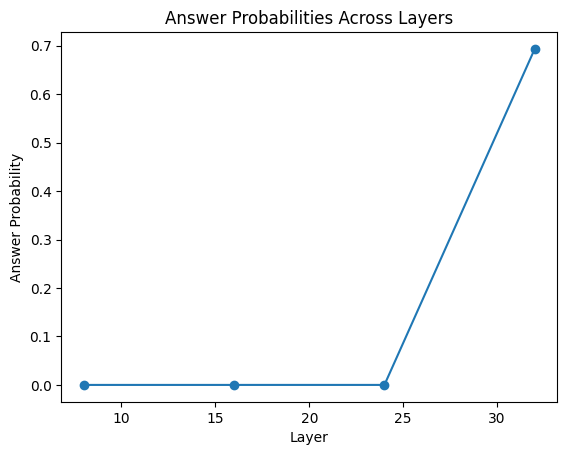

In [19]:
import matplotlib.pyplot as plt

def print_and_plot_probabilities(index):
    combined_data = dataset.loc[index, 'combined_data']
    probabilities = dataset.loc[index, 'answer_probabilities']
    
    print(f"Question: {combined_data['question']}")
    print(f"Answer: {combined_data['answer']}")
    for layer in [8, 16, 24, 32]:
        print(f"Generated Answer {layer}: {combined_data[f'generated_answer_{layer}']}")
    
    layers = [8, 16, 24, 32]
    plt.plot(layers, probabilities, marker='o')
    plt.xlabel('Layer')
    plt.ylabel('Answer Probability')
    plt.title('Answer Probabilities Across Layers')
    plt.show()

print_and_plot_probabilities(0)  # Pass the index of the row you want to visualize


In [10]:
dataset.to_csv('/workspace/storage/fatemeh/organized_projects/NLP_hw2/layers_responses.csv', sep='\t')

# import pandas as pd

# dataset = pd.read_csv('/workspace/storage/fatemeh/organized_projects/NLP_hw2/layers_responses.csv', sep='\t', index_col=0).reset_index(drop=True)
# dataset.head(30)

In [12]:
def calculate_accuracy(dataset, layers):
    accuracies = {}
    
    for layer in layers:
        correct = 0
        total = len(dataset)
        
        for _, row in dataset.iterrows():
            correct_answer = row['answer'].strip().lower()
            generated_answer = row[f'layer_{layer}']['generated_answer'].strip().lower()
            
            if correct_answer in generated_answer:
                correct += 1
                
        accuracy = correct / total
        accuracies[layer] = accuracy
        print(f"Layer {layer} Accuracy: {int(accuracy * 100)}")
    
layers = [8, 16, 24, 32]
calculate_accuracy(dataset, layers)

Layer 8 Accuracy: 0
Layer 16 Accuracy: 16
Layer 24 Accuracy: 40
Layer 32 Accuracy: 93
